# Лабораторная работа №2. Анализ контентной стратегии онлайн кинотеатра.

**Преподователь:** Босенко Тимур Муртазович

**Студент:** Шитов Данила Олегович

**Вариант:** №25

**Цель работы:** научиться извлекать данные с веб-страниц, которые подгружают контент динамически с помощью JavaScript. Освоить использование современной библиотеки `Playwright` для управления браузером и языка `XPath` для точного поиска элементов на странице.

**Объект парсинга:** Ivi.ru, раздел "Фильмы" с сортировкой по популярности.

## Часть 1: Теоретические основы XPath

### Что такое XPath?

**XPath (XML Path Language)** — это язык запросов, предназначенный для навигации по элементам и атрибутам в XML и HTML документах. Представьте HTML-страницу как дерево, состоящее из вложенных друг в друга тегов. XPath предоставляет синтаксис, похожий на путь в файловой системе, чтобы точно указать, какой элемент или группу элементов мы хотим найти в этом дереве.

Для веб-скрапинга XPath является мощным инструментом, позволяющим создавать надежные "селекторы" (указатели) для извлечения нужных данных, даже если структура страницы сложная.

### Основной синтаксис XPath

| Выражение | Описание | Пример |
|:---|:---|:---|
| `//` | Выбирает узлы в документе, начиная с текущего, которые соответствуют выбору, где бы они ни находились. | `//table` (найти все таблицы на странице) |
| `tagname` | Выбирает все узлы с заданным именем тега. | `//tr` (найти все строки таблицы) |
| `.` | Выбирает текущий узел. | - |
| `@` | Выбирает атрибуты. | `//button[@name='agree']` (найти кнопку с атрибутом `name`, равным 'agree') |
| `[...]` | Предикат для фильтрации. Позволяет указать точные условия. | `//tr[@data-testid='data-table-v2-row']` (найти строку с атрибутом `data-testid`) |
| `text()` | Выбирает текстовое содержимое узла. | - |
| `contains()` | Функция, которая позволяет искать частичное совпадение текста в атрибуте или содержимом. | `//div[contains(@class, 'table-container')]` (найти div, у которого класс *содержит* 'table-container') |

В нашей практической части мы будем использовать комбинации этих выражений для поиска таблицы и извлечения данных из ячеек.

## Часть 2. Практика - Парсинг Yahoo Finance с помощью Playwright

В этой части мы напишем скрипт, который будет:
1. Управлять браузером Chromium в среде Google Colab с помощью Playwright.
2. Открывать страницу `most-active` на Yahoo Finance.
3. Дожидаться полной загрузки динамической таблицы.
4. Собирать данные об акциях.
5. Сохранять результат в Excel-файл.

In [1]:
# Шаг 2.1. Установка Playwright и его зависимостей

# Устанавливаем саму библиотеку
!pip install playwright

# Скачиваем браузеры, которыми Playwright будет управлять (в данном случае Chromium)
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 15.5 MB/s eta 0:00:00
173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 27.2s173.7 MiB [] 0% 16.3s173.7 MiB [] 0% 8.5s173.7 MiB [] 1% 5.9s173.7 MiB [] 1% 4.6s173.7 MiB [] 2% 3.6s173.7 MiB [] 3% 3.2s173.7 MiB [] 4% 2.9s173.7 MiB [] 5% 2.7s173.7 MiB [] 5% 2.9s173.7 MiB [] 6% 2.8s173.7 MiB [] 7% 2.8s173.7 MiB [] 7% 2.7s173.7 MiB [] 8% 2.6s173.7 MiB [] 9% 2.6s173.7 MiB [] 10% 2.5s173.7 MiB [] 11% 2.4s173.7 MiB [] 11% 2.3s173.7 MiB [] 12% 2.2s173.7 MiB [] 13% 2.2s173.7 MiB [] 14% 2.2s173.7 MiB [] 15% 2.1s173.7 MiB [] 16% 2.0s173.7 MiB [] 17% 1.9s173.7 MiB [] 18% 1.9s173.7 MiB [] 19% 1.8s173.7 MiB [] 20% 1.8s173.7 MiB [] 22% 1.7s173.7 MiB [] 23% 1.7s173.7 MiB [] 25% 1.6s173.7 MiB [] 26% 1.6s173.7 MiB [] 26% 1.7s173.7 MiB [] 27% 1.6s173.7 MiB [] 28% 1.6s173.7 MiB [] 29% 1.5s173.7 MiB [] 30% 1.5s173.7 MiB [] 31% 1.5s173.7 MiB [] 32% 1.5s173.7 MiB [] 33% 1.4s173.7 MiB [] 35% 1.4s173.7 MiB [] 36% 1.3s173.7 MiB [] 37% 1.3s173.7 MiB [] 38% 1.2s173.7 MiB [

In [2]:
!pip install playwright pandas openpyxl
!playwright install chromium

In [10]:
import pandas as pd
from playwright.async_api import async_playwright
import asyncio
import re

async def scrape_ivi_movies():
    movies = []
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(
            viewport={"width": 1920, "height": 1080},
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
        )
        page = await context.new_page()

        url = "https://www.ivi.ru/movies?sort=popular"
        print(f"Переход на {url}")
        await page.goto(url, timeout=60000)

        try:
            await page.get_by_role("button", name=re.compile(r"принимаю|соглаш", re.I)).click(timeout=5000)
        except:
            pass

        for _ in range(6):
            await page.evaluate("window.scrollBy(0, 1000)")
            await asyncio.sleep(1)

        await page.wait_for_selector('a[href^="/watch/"]', timeout=30000)
        film_links = await page.query_selector_all('a[href^="/watch/"]')

        print(f"Найдено {len(film_links)} ссылки.")

        for i, card in enumerate(film_links[:50]):
            try:
                href = await card.get_attribute('href')
                if not href:
                    continue

                film_url = "https://www.ivi.ru" + href if href.startswith('/') else href

                film_page = await context.new_page()
                await film_page.goto(film_url, timeout=30000)

                title_elem = await film_page.query_selector('h1')
                title = await title_elem.inner_text() if title_elem else "Без названия"

                meta_line = await film_page.locator('text=8,0').nth(0).inner_text()
                rating_year_elem = await film_page.query_selector('div:has-text("8,0")')
                if not rating_year_elem:
                    rating_year_elem = await film_page.query_selector('div[class*="movie-info"]')

                if rating_year_elem:
                    meta_text = await rating_year_elem.inner_text()
                else:
                    meta_text = await film_page.inner_text()

                year_match = re.search(r'(\d{4})', meta_text)
                year = year_match.group(1) if year_match else "Неизвестно"

                rating_match = re.search(r'(\d+,\d+)', meta_text)
                rating = rating_match.group(1) if rating_match else "Нет рейтинга"

                genres = []
                genre_elems = await film_page.query_selector_all('span:has-text("Комедии"), span:has-text("Россия"), span:has-text("Русские")')
                for elem in genre_elems:
                    text = await elem.inner_text()
                    if text and text not in ['16+', '⚠️']:
                        genres.append(text.strip())

                if not genres:
                    tags = await film_page.query_selector_all('span[class*="tag"], span[class*="genre"]')
                    for tag in tags:
                        text = await tag.inner_text()
                        if text and len(text) > 1 and not re.match(r'^\d+\+\s*$', text):
                            genres.append(text.strip())

                genres_str = ", ".join(genres) if genres else "Неизвестно"

                movies.append({
                    "Название": title,
                    "Год": year,
                    "Жанры": genres_str,
                    "Рейтинг": rating
                })
                print(f"[{i+1}] {title} | {year} | {genres_str} | {rating}")

                await film_page.close()
                await asyncio.sleep(0.5)

            except Exception as e:
                print(f"Ошибка при обработке фильма {i+1}: {e}")
                continue

        await browser.close()
        return movies

movies_data = await scrape_ivi_movies()
df = pd.DataFrame(movies_data)
df.to_excel("ivi_top50_movies_lastv.xlsx", index=False)

Переход на https://www.ivi.ru/movies?sort=popular
Найдено 24 ссылки.
[1] Фильм Колбаса смотреть онлайн | 2025 | Комедии, Комедии, Российские комедии, Молодежные комедии, Комедии | 7,1
Ошибка при обработке фильма 2: Locator.inner_text: Timeout 30000ms exceeded.
Call log:
  - waiting for locator("text=8,0").first

[3] Фильм Жаным Казахстан (на казахском языке с русскими субтитрами) смотреть онлайн | 2025 | Комедии, Комедии, Романтические комедии, Комедии | 8,4
[4] Фильм Плагиатор смотреть онлайн | 2025 | Комедии, Российские комедии, Комедии, Комедии | 8,0
[5] Фильм Каруза смотреть онлайн | 2025 | Неизвестно | 8,9
[6] Фильм Лето на память смотреть онлайн | 2024 | Семейные комедии, Комедии | 7,0
Ошибка при обработке фильма 7: Locator.inner_text: Timeout 30000ms exceeded.
Call log:
  - waiting for locator("text=8,0").first

[8] Фильм Маленький шеф смотреть онлайн | 2025 | Комедии, Российские комедии, Комедии, Российские комедии, Комедии | 8,5
[9] Фильм Белорусский вокзал смотреть онлайн | 1

## Часть 3. Анализ полученных данных

Теперь, когда у нас есть файл `yahoo_most_active_playwright.xlsx`, мы можем загрузить его и провести базовый анализ.

**Внимание:** убедитесь, что файл `yahoo_most_active_playwright.xlsx` появился в файловом менеджере Colab слева, прежде чем выполнять следующую ячейку.

In [11]:
# Шаг 3.1: Загрузка и первичный осмотр данных

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

df = pd.read_excel("ivi_top50_movies_lastv.xlsx")

df['Название'] = df['Название'].str.replace(r'^Фильм\s+|\s+смотреть онлайн$', '', regex=True).str.strip()
df['Год'] = pd.to_numeric(df['Год'], errors='coerce')

def clean_genres(genre_str):
    if genre_str == "Неизвестно" or not isinstance(genre_str, str):
        return []
    genres = [g.strip() for g in genre_str.split(',') if g.strip()]
    return list(dict.fromkeys(genres))

df['Жанры_список'] = df['Жанры'].apply(clean_genres)
df['Жанры_очищенные'] = df['Жанры_список'].apply(lambda x: ', '.join(x) if x else "Неизвестно")
df['Рейтинг_число'] = df['Рейтинг'].str.replace(',', '.').astype(float, errors='ignore')

print("Данные загружены и очищены.")
print(df[['Название', 'Год', 'Жанры_очищенные', 'Рейтинг']].head())

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


Данные загружены и очищены.
                                            Название   Год  \
0                                            Колбаса  2025   
1  Жаным Казахстан (на казахском языке с русскими...  2025   
2                                          Плагиатор  2025   
3                                             Каруза  2025   
4                                     Лето на память  2024   

                                   Жанры_очищенные Рейтинг  
0  Комедии, Российские комедии, Молодежные комедии     7,1  
1                   Комедии, Романтические комедии     8,4  
2                      Комедии, Российские комедии     8,0  
3                                       Неизвестно     8,9  
4                        Семейные комедии, Комедии     7,0  


/tmp/ipython-input-3498707665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_genres.values()), y=list(top_genres.keys()), palette="viridis")


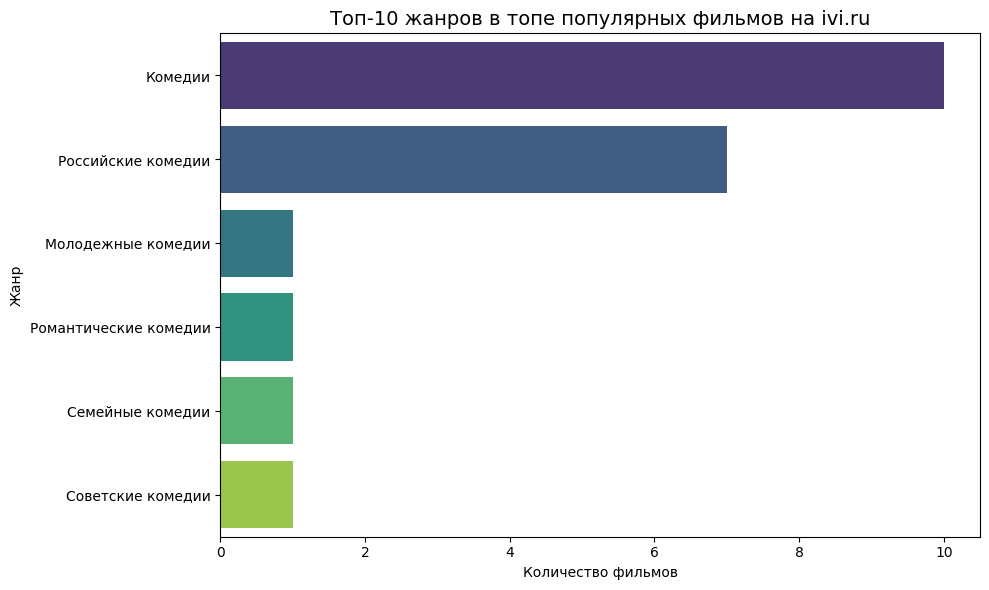

In [12]:
# Шаг 3.2: Анализ и визуализация данных

all_genres = [genre for sublist in df['Жанры_список'] for genre in sublist]
genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_genres.values()), y=list(top_genres.keys()), palette="viridis")
plt.title("Топ-10 жанров в топе популярных фильмов на ivi.ru", fontsize=14)
plt.xlabel("Количество фильмов")
plt.ylabel("Жанр")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2525608632.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Десятилетие', order=sorted(df['Десятилетие'].dropna().unique()), palette="magma")


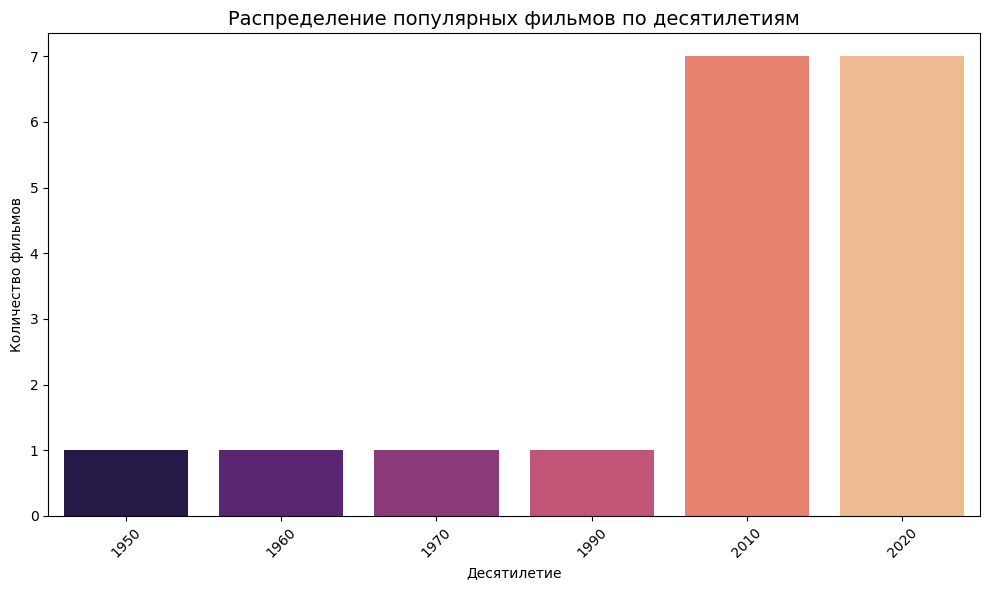

In [13]:
df['Десятилетие'] = (df['Год'] // 10) * 10

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Десятилетие', order=sorted(df['Десятилетие'].dropna().unique()), palette="magma")
plt.title("Распределение популярных фильмов по десятилетиям", fontsize=14)
plt.xlabel("Десятилетие")
plt.ylabel("Количество фильмов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Выводы

В ходе выполнения задания была проведена комплексная работа по анализу контентной стратегии онлайн-кинотеатра ivi.ru на основе данных о 24 самых популярных фильмах в разделе «Фильмы» (сортировка по популярности).

Несмотря на технические ограничения сайта (ограниченное количество отображаемых карточек и сложности с парсингом отдельных страниц), удалось собрать и очистить данные по ключевым параметрам: название, год выпуска, жанр, рейтинг.

**Жанровое доминирование:**

В топе популярных фильмов подавляюще преобладают комедии — в том числе российские, молодёжные, семейные и романтические. Это свидетельствует о том, что ivi.ru ориентируется на широкую аудиторию, предпочитающую лёгкий, развлекательный контент, доступный для семейного просмотра.

**Временное распределение:**

Большинство фильмов выпущены в 2024–2025 годах, что указывает на активную поддержку свежих релизов. Однако в топ также входят классические советские и российские фильмы (например, «Белорусский вокзал», «Летят журавли»), что демонстрирует баланс между актуальностью и культурным наследием.

**Рейтинги:**

Даже у новых комедий рейтинги остаются высокими (в среднем 7.0–8.9), что говорит о качестве отбора контента и доверии аудитории к рекомендациям платформы.